## Problem Setup

### Poisson equation (1D)

$$-\frac{\partial^2 u}{\partial x^2} = f(x)$$

 

### Problem

$$-\frac{\partial^2 u}{\partial x^2}=\nu^2\pi^2sin(\nu\pi x)$$

### Boundary Conditions:

$$u(-1) = 0, \  u(1) =0$$

### Exact solution:

$$u(x)= sin(\nu\pi x)$$


So the residual will be:

$$0=\frac{\partial^2u}{\partial x^2}+\nu^2\pi^2sin(\nu\pi x)$$

# Transfer Learning Source 

In [465]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cpu


### Parameters setting

In [466]:
steps=5000
nus = [1,2,3]
lr=1e-3
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
# To generate new data:
x_l=-1
x_r=1

total_points=800
#Nu: Number of training points (2 as we onlt have 2 boundaries), # Nf: Number of collocation points (Evaluate PDE)
Nf=total_points

### Functions

In [467]:
def f_BC(x):
    return 1-torch.abs(x)


def f_real(x,nu):
    return torch.sin(nu*np.pi*x)

# def PDE(x):
#     return -nu*(np.pi**2)*torch.sin(np.pi*x)
    

### Data generation

In [468]:
# Plot the function as a 3D heatmap
x = torch.linspace(x_l,x_r,total_points).view(-1,1) #prepare to NN



# Transform the mesh into a 2-column vector
x_test=x

 
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value 





#Boundary Conditions
#Left Edge 
left_X=lb
vleft_boundary = f_BC(lb)

#right Edge
right_X=ub
vright_boundary = f_BC(ub)
    
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(1,Nf) # 2 as the inputs are x and y

X_train_Nu =torch.vstack([left_X,right_X]) 
v_train_Nu=torch.vstack([vleft_boundary,vright_boundary])  




torch.manual_seed(123)
#Store tensors to GPU

X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function


X_test=x_test.float().to(device) # the input dataset (complete)
V_test=v_test.float().to(device) # the real solution 

### Neural Network

In [469]:
class PINN(nn.Module):
    ##Neural Network
    def __init__(self,layers,nu):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        self.nu = nu
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):

            
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,X):
        if torch.is_tensor(X) != True:         
            X = torch.from_numpy(X)                
        a = X.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,X_BC,f_BC):
        loss_BC=self.loss_function(self.forward(X_BC),f_BC)
        return loss_BC
    #Loss PDE
    def lossPDE(self,X_PDE):
        g=X_PDE.clone()
        g.requires_grad=True #Enable differentiation
        f=self.forward(g)
        f_X=autograd.grad(f,g,grad_outputs=torch.ones_like(f),create_graph=True)[0] #first derivative    
        grad_x =   f_X[:,0]
       
        f_XX = autograd.grad(grad_x, g, grad_outputs=torch.ones_like(grad_x), create_graph=True)[0][:, 0]
        
        solu = np.pi ** 2 *torch.sin(self.nu*np.pi * g[:, 0:1])
        delta_f=f_XX.unsqueeze(1) + self.nu**2*solu
        
         
        
        
        return self.loss_function(delta_f,f_hat)
#     + 2*np.pi ** 2 *torch.sin(np.pi * g[:, 0:1])*torch.sin(np.pi * g[:, 1:])
        
    def loss(self,X_BC,f_BC,X_PDE):
        loss_bc=self.lossBC(X_BC,f_BC)
        loss_pde=self.lossPDE(X_PDE)
        return loss_bc+loss_pde
#X_train_Nu,v_train_Nu,X_train_Nf

### Model training

In [470]:
%%time
for nu in nus:
    f = f_real(x,nu)
    v_test=f.flatten() 
    
    model = PINN(layers,nu)
    print(model)
    model.to(device)
    params = list(model.parameters())
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=False)
    start_time = time.time()

    model.lossBC(X_train_Nu,v_train_Nu)
    
    
    
    
    error_i = []
    epochs = []
    loss_i = []
    for i in range(steps):

        loss = model.loss(X_train_Nu,v_train_Nu,X_train_Nf)# use mean squared error
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i%200==0:
            print(loss)
            yf = model(X_test)
            _, id_train = torch.sort(X_test.squeeze(1))
            X_test_plot = X_test[id_train]
            yf_plot = yf[id_train]
            f_plot = f[id_train]
            error_u = np.linalg.norm(yf_plot.detach().numpy()-f_plot.detach().numpy(),2)/np.linalg.norm(f_plot.detach().numpy(),2)
            print('error_u',error_u)

            epochs.append(i)
            error_i.append(error_u)
            loss_i.append(loss)
            
             
            
#     model_name = 'model_nn/Source_Model_nu_{}'.format(nu)    
#     loss_name = 'model_nn/Source_loss_nu_{}'.format(nu)
#     error_name = 'model_nn/Source_error_nu_{}'.format(nu)
    

#     # Save the model's state dictionary
#     torch.save(model.state_dict(), model_name)
#     torch.save(loss_i, loss_name)
#     torch.save(error_i, error_name)

PINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)
tensor(48.2836, grad_fn=<AddBackward0>)
error_u 0.83667827
tensor(0.0686, grad_fn=<AddBackward0>)
error_u 0.02909513
tensor(0.0176, grad_fn=<AddBackward0>)
error_u 0.009392824
tensor(0.0110, grad_fn=<AddBackward0>)
error_u 0.005783987
tensor(0.0054, grad_fn=<AddBackward0>)
error_u 0.0038464197
tensor(0.0030, grad_fn=<AddBackward0>)
error_u 0.002101146
tensor(0.0023, grad_fn=<AddBackward0>)
error_u 0.0013346474
tensor(0.0018, grad_fn=<AddBackward0>)
error_u 0.00077465497
tensor(0.0015, grad_fn=<AddBackward0>)
error_u 0.000559458
tensor(0.0011, grad

In [353]:
def plot_1d(x,y,x_train_plot,yh_plot):
    
    _, ax = plt.subplots()
    ax.plot(x.detach().numpy(), y.detach().numpy(), color='blue', label='Pred_Train')
    ax.plot(x.detach().cpu().numpy(), yh_plot.detach().cpu().numpy(), color='red', label='Real_Train')
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('f(x)', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc='upper left')
    

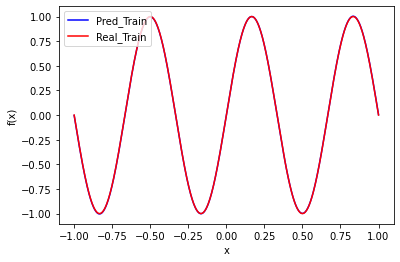

In [357]:
path = 'model_nn/Source_Model_nu_3'
model.load_state_dict(torch.load(path))

yf = model(X_test)
_, id_train = torch.sort(X_test.squeeze(1))
X_test_plot = X_test[id_train]
yf_plot = yf[id_train]
f_plot = f[id_train]
 
plot_1d(X_test_plot,yf_plot,X_test_plot,f_plot)
 
 
 



## -----------------------------------------------------------------------------------------------------------------------------
## -----------------------------------------------------------------------------------------------------------------------------
## -----------------------------------------------------------------------------------------------------------------------------
## -----------------------------------------------------------------------------------------------------------------------------
## -----------------------------------------------------------------------------------------------------------------------------

# Transfer Learning Target

In [38]:
nus = [1,2,3]

# previous model

In [44]:
class PINN(nn.Module):
    ##Neural Network
    def __init__(self,layers,nu):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        self.nu = nu
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))


        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)  
                
                
                
    'foward pass'
    def forward(self,X):
        if torch.is_tensor(X) != True:         
            X = torch.from_numpy(X)                
        a = X.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,X_BC,f_BC):
        loss_BC=self.loss_function(self.forward(X_BC),f_BC)
        return loss_BC
    #Loss PDE
    def lossPDE(self,X_PDE):
        g=X_PDE.clone()
        g.requires_grad=True #Enable differentiation
        f=self.forward(g)
        f_X=autograd.grad(f,g,grad_outputs=torch.ones_like(f),create_graph=True)[0] #first derivative    
        grad_x =   f_X[:,0]
       
        f_XX = autograd.grad(grad_x, g, grad_outputs=torch.ones_like(grad_x), create_graph=True)[0][:, 0]
        
        solu = np.pi ** 2 *torch.sin(self.nu*np.pi * g[:, 0:1])
        delta_f=f_XX.unsqueeze(1) + self.nu**2*solu
        
         
        
        
        return self.loss_function(delta_f,f_hat)
#     + 2*np.pi ** 2 *torch.sin(np.pi * g[:, 0:1])*torch.sin(np.pi * g[:, 1:])
        
    def loss(self,X_BC,f_BC,X_PDE):
        loss_bc=self.lossBC(X_BC,f_BC)
        loss_pde=self.lossPDE(X_PDE)
        return loss_bc+loss_pde
#X_train_Nu,v_train_Nu,X_train_Nf



# New model

In [130]:
class PINN_model(nn.Module):
    ##Neural Network
    def __init__(self,layers,nu):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        self.nu = nu
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        with torch.no_grad():
            for new_param, existing_param in zip(self.parameters(), existing_model.parameters()):
                new_param.data = existing_param.data 


#         for i in range(len(layers)-1):
#             nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
#             # set biases to zero
#             nn.init.zeros_(self.linears[i].bias.data)  
                
                
                
    'foward pass'
    def forward(self,X):
        if torch.is_tensor(X) != True:         
            X = torch.from_numpy(X)                
        a = X.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,X_BC,f_BC):
        loss_BC=self.loss_function(self.forward(X_BC),f_BC)
        return loss_BC
    #Loss PDE
    def lossPDE(self,X_PDE):
        g=X_PDE.clone()
        g.requires_grad=True #Enable differentiation
        f=self.forward(g)
        f_X=autograd.grad(f,g,grad_outputs=torch.ones_like(f),create_graph=True)[0] #first derivative    
        grad_x =   f_X[:,0]
       
        f_XX = autograd.grad(grad_x, g, grad_outputs=torch.ones_like(grad_x), create_graph=True)[0][:, 0]
        
        solu = np.pi ** 2 *torch.sin(self.nu*np.pi * g[:, 0:1])
        delta_f=f_XX.unsqueeze(1) + self.nu**2*solu
        
         
        
        
        return self.loss_function(delta_f,f_hat)
#     + 2*np.pi ** 2 *torch.sin(np.pi * g[:, 0:1])*torch.sin(np.pi * g[:, 1:])
        
    def loss(self,X_BC,f_BC,X_PDE):
        loss_bc=self.lossBC(X_BC,f_BC)
        loss_pde=self.lossPDE(X_PDE)
        return loss_bc+loss_pde
#X_train_Nu,v_train_Nu,X_train_Nf



In [131]:
steps=15000
nu_target = 4
lr=1e-3
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
# To generate new data:
x_l=-1
x_r=1

total_points=800
#Nu: Number of training points (2 as we onlt have 2 boundaries), # Nf: Number of collocation points (Evaluate PDE)
Nf=total_points


In [132]:
def f_BC(x):
    return 1-torch.abs(x)


def f_real(x,nu):
    return torch.sin(nu*np.pi*x)

def find_closest_value(input_list, target_value):
    closest_value = min(input_list, key=lambda x: abs(x - target_value))
    return closest_value

In [133]:
nu_source = find_closest_value(nus, nu_target)
print(nu_source)
    

existing_model = PINN(layers,nu_source)
path = 'model_nn/Source_Model_nu_{}'.format(nu_source)
existing_model.load_state_dict(torch.load(path))

3


<All keys matched successfully>

In [134]:
model_new = PINN_model(layers,nu_target)

model_new.to(device)

PINN_model(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [135]:
# Plot the function as a 3D heatmap
x = torch.linspace(x_l,x_r,total_points).view(-1,1) #prepare to NN



# Transform the mesh into a 2-column vector
x_test=x

 
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value 





#Boundary Conditions
#Left Edge 
left_X=lb
vleft_boundary = f_BC(lb)

#right Edge
right_X=ub
vright_boundary = f_BC(ub)
    
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(1,Nf) # 2 as the inputs are x and y

X_train_Nu =torch.vstack([left_X,right_X]) 
v_train_Nu=torch.vstack([vleft_boundary,vright_boundary])  




torch.manual_seed(123)
#Store tensors to GPU

X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function


X_test=x_test.float().to(device) # the input dataset (complete)
V_test=v_test.float().to(device) # the real solution     


f = f_real(X_test,nu_target)
v_test=f.flatten() 

In [136]:
params = list(model_new.parameters())

optimizer = torch.optim.Adam(model_new.parameters(), lr=lr, amsgrad=False)


In [137]:

model_new.lossBC(X_train_Nu,v_train_Nu)

tensor(1.9957e-05, grad_fn=<MseLossBackward>)

In [138]:
%%time
error_i = []
epochs = []
loss_i = []
for i in range(steps):
     
    loss = model_new.loss(X_train_Nu,v_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%200==0:
        print(loss)
        yf = model_new(X_test)
        _, id_train = torch.sort(X_test.squeeze(1))
        X_test_plot = X_test[id_train]
        yf_plot = yf[id_train]
        f_plot = f[id_train]
        error_v = np.linalg.norm(yf_plot.detach().numpy()-f_plot.detach().numpy(),2)/np.linalg.norm(f_plot.detach().numpy(),2)
        print('error_u',error_v)
        
        epochs.append(i)
        error_i.append(error_v)
        loss_i.append(loss)


tensor(16418.3926, grad_fn=<AddBackward0>)
error_u 1.2846196
tensor(642.0907, grad_fn=<AddBackward0>)
error_u 0.9703299
tensor(352.3809, grad_fn=<AddBackward0>)
error_u 1.778772
tensor(225.3580, grad_fn=<AddBackward0>)
error_u 4.073172
tensor(171.9732, grad_fn=<AddBackward0>)
error_u 5.3412986
tensor(87.1494, grad_fn=<AddBackward0>)
error_u 6.0646906
tensor(49.9066, grad_fn=<AddBackward0>)
error_u 5.3338737
tensor(29.3467, grad_fn=<AddBackward0>)
error_u 4.1163716
tensor(18.1846, grad_fn=<AddBackward0>)
error_u 3.157982
tensor(11.6833, grad_fn=<AddBackward0>)
error_u 2.4622228
tensor(9.9696, grad_fn=<AddBackward0>)
error_u 1.920213
tensor(4.8125, grad_fn=<AddBackward0>)
error_u 1.4757577
tensor(2.8271, grad_fn=<AddBackward0>)
error_u 1.0993743
tensor(1.4439, grad_fn=<AddBackward0>)
error_u 0.7787317
tensor(6.7284, grad_fn=<AddBackward0>)
error_u 0.52248734
tensor(0.4074, grad_fn=<AddBackward0>)
error_u 0.32418588
tensor(0.2037, grad_fn=<AddBackward0>)
error_u 0.19238013
tensor(0.5423, 

In [139]:
print(error_i)

[1.2846196, 0.9703299, 1.778772, 4.073172, 5.3412986, 6.0646906, 5.3338737, 4.1163716, 3.157982, 2.4622228, 1.920213, 1.4757577, 1.0993743, 0.7787317, 0.52248734, 0.32418588, 0.19238013, 0.12336558, 0.06538183, 0.04292987, 0.025671631, 0.027647989, 0.019609785, 0.015794763, 0.029055677, 0.00937679, 0.008970339, 0.01881191, 0.00770272, 0.0066755787, 0.0064951805, 0.0068649007, 0.0059969486, 0.009415848, 0.0053715464, 0.013336187, 0.005323154, 0.0049313945, 0.0053466577, 0.010504051, 0.025232477, 0.017514998, 0.024745967, 0.005345733, 0.0039541433, 0.003447806, 0.00870018, 0.013422331, 0.0041283714, 0.0039116675, 0.017786408, 0.018156925, 0.01832561, 0.009085912, 0.004121198, 0.00922087, 0.0025882819, 0.0038693019, 0.006680769, 0.012578126, 0.013510449, 0.008905772, 0.008452499, 0.024823362, 0.005369798, 0.0023726823, 0.015515789, 0.0034617647, 0.029919395, 0.013030069, 0.007921046, 0.007994047, 0.015266149, 0.014876334, 0.014915451]


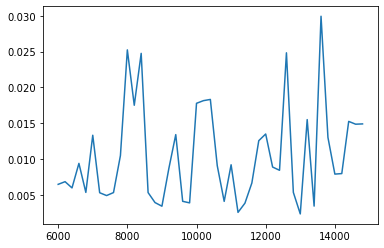

In [140]:
plt.plot(epochs[30:],error_i[30:])

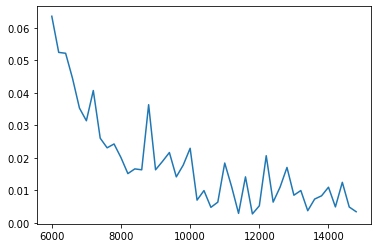

In [127]:
plt.plot(epochs[30:],error_i[30:])

In [141]:
def plot_1d(x,y,x_train_plot,yh_plot):
    
    _, ax = plt.subplots()
    ax.plot(x.detach().numpy(), y.detach().numpy(), color='blue', label='Pred_Train')
    ax.plot(x.detach().cpu().numpy(), yh_plot.detach().cpu().numpy(), color='red', label='Real_Train')
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('f(x)', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc='upper left')

tensor(8.6427e-06, grad_fn=<MinBackward1>)
tensor(0.0136, grad_fn=<MaxBackward1>)


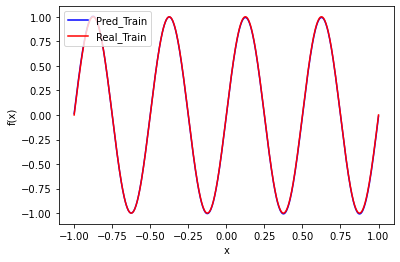

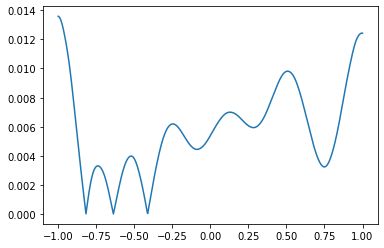

In [142]:
yf = model_new(X_test)
_, id_train = torch.sort(X_test.squeeze(1))
X_test_plot = X_test[id_train]
yf_plot = yf[id_train]
f_plot = f[id_train]
 

plot_1d(X_test_plot,yf_plot,X_test_plot,f_plot)
_, ax = plt.subplots()
ax.plot(X_test_plot.detach().numpy(),abs(yf_plot.detach().numpy()-f_plot.detach().numpy()))
 

print(torch.min(abs(yf_plot - f_plot)))
print(torch.max(abs(yf_plot - f_plot)))